# Laboratory 2.2: Source Localization

**Objectives:** 

- Create a graph using a stochastic block model (SBM).
- Implement a graph neural network (GNN) to determine which community originated a certain graph signal.
- Analyse the effect of varying levels of noise and number of communities.

**Completion requirements:**

By the end of this notebook, you should have:
- Implemented all code cells for:
  - defining a GNN-model. 
  - training the GNN-model
  - assesing the performance of the GNN-model.
- Answered the analysis questions on each section. 

## 🔙 Background

Graphs such as social networks can be divided in communities based on common traits. In several tasks, we are interested in finding the source of the information. In other words, which community is responsible for generating a fake news, outbreak, epidemics, or rumor.
To determine where a signal originated from we can use graph based tools such as GNNs.
In the source localization problem, we have to estimate which community $c$ originated the diffusion, by observing graph signals and knowing the topology.

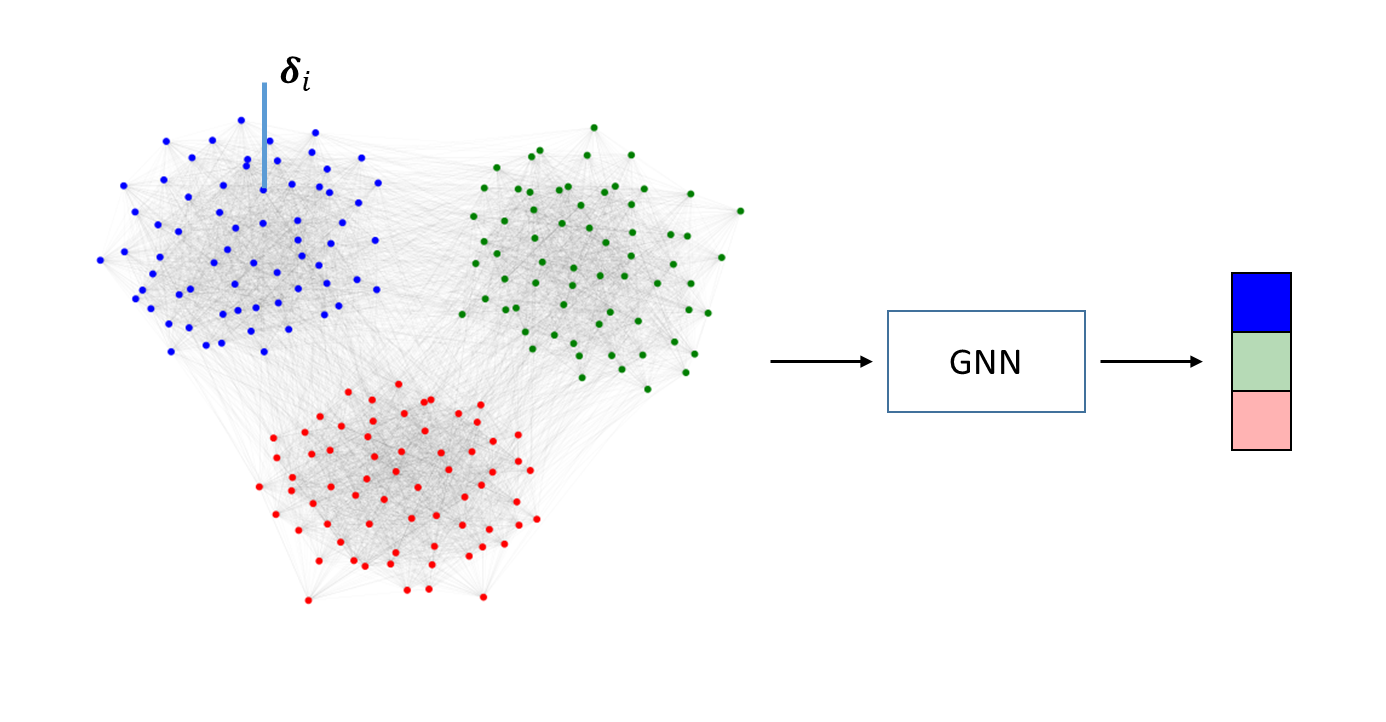


## ⛔ Problem definition 

In this notebook, you are asked to create a graph neural network (GNN) to determine the community which originated a certain graph signal.
This problem is a supervised graph signal classification given a training set of input-output pairs $(\mathbf{x}, c)$, where $c$ is the community that has originated the diffusion and $\mathbf{x}$ is the graph signal. 
The output can be given by a one-hot vector on the number of communities, and we can use a cross-entropy loss for training.

<u> Dataset details </u>

In this laboratory, we consider a synthetic dataset created via a stochastic block model graph with $C$ communities. We generate the data by diffusing unitary signals from different source nodes and sampling it after a certain number of diffusion steps. Your task will then be to determine from which community the signal is originated from.

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

To run this notebook you need to have installed the following packages:
- Numpy
- NetworkX
- Pytorch
- Pytorch geometric

In [1]:
import torch
import networkx as nx
import numpy as np
from torch.nn.functional import one_hot
import scipy

from torch_geometric.utils import from_networkx
from torch_geometric.data import Data


## Create a graph using a stochastic block model (SBM)
First of all you need to create a function that generates a graph with $C$ number of communities using a stochastic block model.
The function should have as arguments the number of nodes of the graph, the number of communities, and the probabilties of creating an edge inside a community and among different communities

In [2]:
def generate_sbm_graph(num_nodes, num_communities=2, 
                       intra_prob=0.8, inter_prob=0.1, seed=42):
  """
  Description:
  
  This function generates a graph using the Stochastic Block Model (SBM), 
  which assumes that nodes in a graph belong to one or more communities, 
  and edges between nodes are generated probabilistically based on the community assignments.

  Parameters:

  num_nodes (int): The total number of nodes in the generated graph.
  num_communities (int): The desired number of communities in the generated graph.
  intra_prob (float): The probability of an edge existing between two nodes within the same community.
  inter_prob (float): The probability of an edge existing between two nodes in different communities.
  seed (int): The seed for the random number generator used in generating the graph.

  Returns:

  adjacency_matrix (numpy.ndarray): A 2D array representing the adjacency matrix of the generated graph. 
    The entry at index (i, j) represents the presence (1) or absence (0) of an edge between nodes i and j.
  labels (numpy.ndarray): A 1D numpy array representing the community assignments of each node in the generated graph. 
    The entry at index i represents the community assignment of node i, which is an integer ranging from 0 to num_communities-1.

  Note:
  Be sure to balance the number of nodes in each community.
  """
  np.random.seed(seed)

  # Initializing
  adjacency_matrix = np.zeros((num_nodes, num_nodes))
  labels = np.zeros(num_nodes, dtype=int)

  nodes_per_community = num_nodes // num_communities

  for i in range(num_communities):
    nodes_in_community = range(i * nodes_per_community, (i + 1) * nodes_per_community)
    labels[nodes_in_community] = i

    # add intra community edges
    for node1 in nodes_in_community:
      for node2 in nodes_in_community:
        if np.random.rand() < intra_prob:
          adjacency_matrix[node1, node2] = adjacency_matrix[node2, node1] = 1

    # add inter community edges
    for node1 in nodes_in_community:
      for node2 in range((i + 1) * nodes_per_community, num_nodes):
        if np.random.rand() < inter_prob:
          adjacency_matrix[node1, node2] = adjacency_matrix[node2, node1] = 1


  return adjacency_matrix, labels


In [3]:
num_nodes = 200 # Number of nodes
num_communities = 3 # Number of communities

intra_prob = 0.7 # Probability of drawing edges intra communities
inter_prob = 0.1 # Probability of drawing edges inter communities

adjacency_matrix, labels = generate_sbm_graph(num_nodes, num_communities, intra_prob, inter_prob, seed=42)

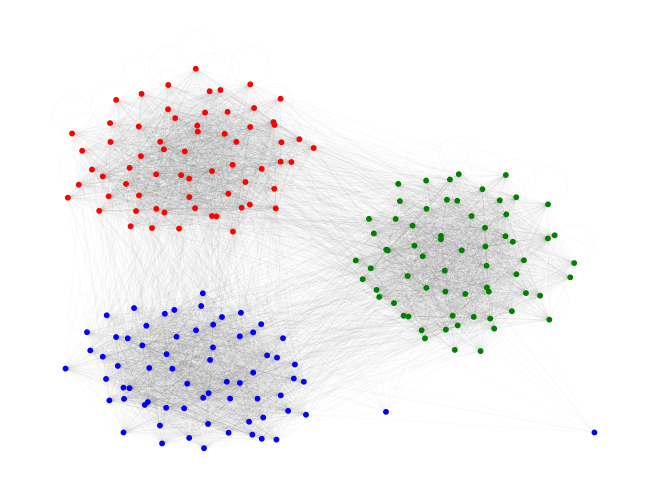

In [4]:
color_mapping=['blue','red','green','purple','pink','black']
color_map = [color_mapping[i] for i in labels]

# Convert adjacency matrix to networkx graph
graph = nx.from_numpy_array(adjacency_matrix)

nx.draw(graph, 
        node_color=color_map,
        node_size=10, width=0.01)

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

* Can you clearly identify the communities? If not, why?

#### Answers:

Yes, the communities are clearly identifiable. They show a good separation between them as expected, since the probability of creating an edge inside a community is much higher than the probability of creating an edge between communities.

When the intra and inter probabilities are close to each other the communities start to merge. 
Otherwise, the networkx plotting tool should clearly highlight the different communities.

## Diffuse the signal from a source node and sample it at a random time
After generating the SBM graph, you are asked to diffuse a unitary node signal following this equation:

$\mathbf{x}_t = \mathbf{S}^t \boldsymbol{\delta}_i + \boldsymbol{\epsilon}_t$

where $\mathbf{x}_t$ is the diffused graph signal $\mathbf{S}$ is the graph shift operator, $\boldsymbol{\delta}_i$ is a graph signal that has a 1 in node $i$ and 0 elsewhere, and $\boldsymbol{\epsilon}_t$ is a Gaussian noise with zero mean and std. deviation $\sigma$. This equation propagates the graph signal $\boldsymbol{\delta}_i$ for $t$ diffusion steps.

Write a function that implements the above equation, given a graph, a source node, the noise standard deviation, and the number of diffusion steps.


In [5]:
def generate_diffusion(adjacency_matrix, source_node, n_diffusions, noise_std=0.01, seed=42):
  """
  Description:
  This function generates a dataset of diffused signals given a source node on a graph represented by an adjacency matrix. 
  The diffusion process is modeled as iteratively multiplying the signal vector with the normalized adjacency matrix, 
  and adding Gaussian noise at each iteration.

  Parameters:

  adjacency_matrix (numpy.ndarray): A 2D numpy array representing the adjacency matrix of the graph.
  source_node (int): Index of the source node from which the diffusion process starts.
  n_diffusions (int): Number of diffusion steps to perform.
  noise_std (float): Standard deviation of the Gaussian noise added at each diffusion step.
  seed (int): The seed for the random number generator used in generating the Gaussian noise.

  Returns:

  signal (torch.Tensor): A 1D tensor representing the final diffused signal after the specified number of diffusion steps. 
    The length of the array is equal to the number of nodes in the graph, 
    and the entry at index i represents the diffused signal value of node i.
  
  Note:
  
  The adjacency matrix is normalized by dividing it by the maximum eigenvalue to avoid exploding values.
  """
  np.random.seed(seed)

  # Normalize the adjacency matrix to avoid exploding values
  e, V = np.linalg.eigh(adjacency_matrix)
  e_max = np.max(e)
  adjacency_matrix = adjacency_matrix / e_max

  # Signal vector
  signal = np.zeros(adjacency_matrix.shape[0])
  signal[source_node] = 1

  # Propagation of the signal and noise
  for _ in range(n_diffusions):
    signal = np.dot(adjacency_matrix, signal)
    signal += np.random.normal(loc=0, scale=noise_std, size=signal.shape)
  
  signal = torch.Tensor(signal)
  return signal # [N]


In [6]:
# Another version of the diffusion function where the adjacency matrix is normalized by row degrees

def generate_diffusion2(adjacency_matrix, source_node, n_diffusions, noise_std=0.01, seed=42):
    """
    This function generates a dataset of diffused signals given a source node on a graph represented by an adjacency matrix. 
    The diffusion process is modeled as iteratively multiplying the signal vector with the normalized adjacency matrix, 
    and adding Gaussian noise at each iteration.

    The adjacency matrix is normalized by row degrees (number of outgoing edges), and noise is applied only to the diffused signal.

    The diffusion_factor parameter controls how much of the signal at each node is propagated to its neighbors at each step,
    with the rest remaining at the node. The noise_factor parameter controls the relative magnitude of the noise compared to 
    the signal at each node.
    """
    np.random.seed(seed)

    diffusion_factor= 0.8
    noise_factor = noise_std   

    # Normalization
    degrees = np.sum(adjacency_matrix != 0, axis=1)
    adjacency_matrix_norm = np.copy(adjacency_matrix)
    for i in range(adjacency_matrix.shape[0]):
        if degrees[i] != 0:
            adjacency_matrix_norm[i, :] /= degrees[i]

    adjacency_matrix_norm_csr = scipy.sparse.csr_matrix(adjacency_matrix_norm)

    # Signal vector
    signal = np.zeros(adjacency_matrix.shape[0])
    signal[source_node] = 1

    # Propagation of the signal and noise
    for _ in range(n_diffusions):
        next_signal = diffusion_factor * adjacency_matrix_norm_csr.dot(signal) + (1 - diffusion_factor) * signal
        noise = np.random.normal(loc=0, scale=noise_factor * np.abs(next_signal), size=next_signal.shape)
        noise[source_node] = 0
        signal = next_signal + noise
  
    signal = torch.Tensor(signal)
    return signal

### Plotting the diffused signal

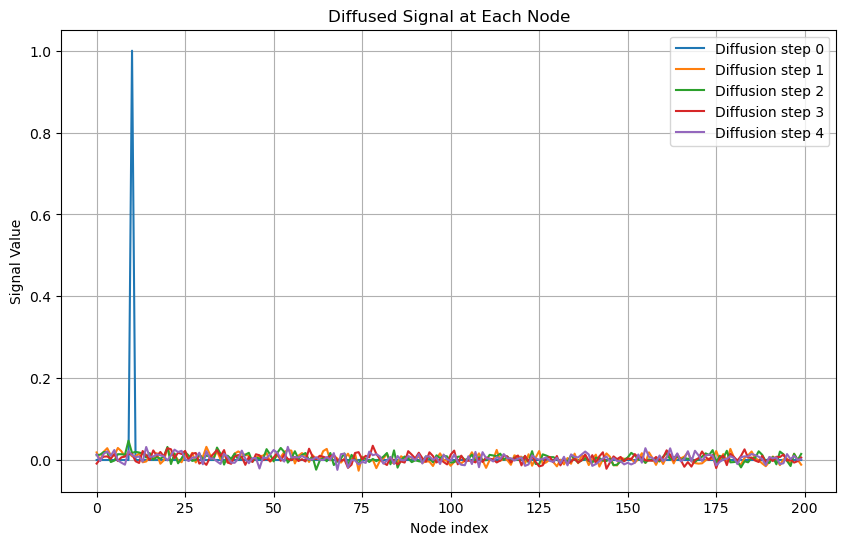

In [7]:
import matplotlib.pyplot as plt

# To verify the previous code
source_node = 10 
n_diffusions = 5

plt.figure(figsize=(10, 6))

for diffusion_i in range(n_diffusions):
    signal = generate_diffusion(adjacency_matrix, source_node, diffusion_i, noise_std=0.01, seed=42)
    plt.plot(signal.tolist(), label=f"Diffusion step {diffusion_i}")

plt.xlabel("Node index")
plt.ylabel("Signal Value")
plt.title("Diffused Signal at Each Node")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

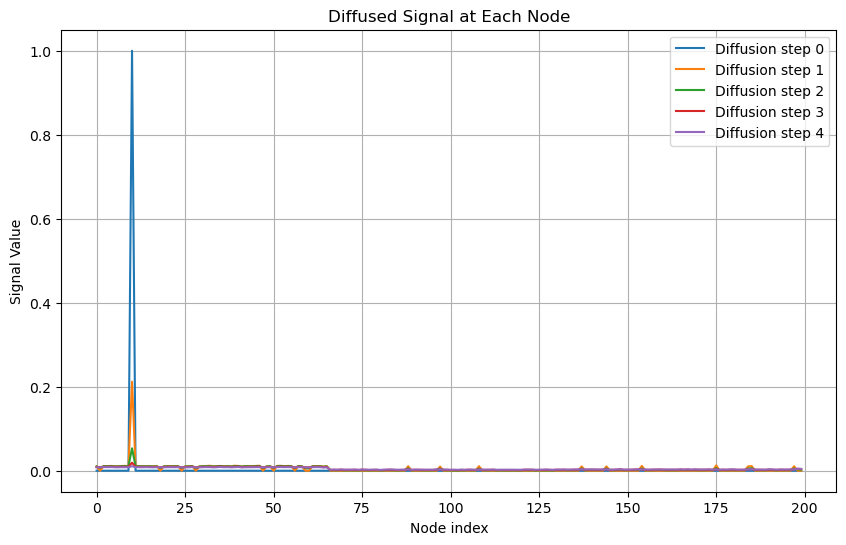

In [8]:
import matplotlib.pyplot as plt

# To verify the previous code
source_node = 10 
n_diffusions = 5

plt.figure(figsize=(10, 6))

for diffusion_i in range(n_diffusions):
    signal = generate_diffusion2(adjacency_matrix, source_node, diffusion_i, seed=42)
    plt.plot(signal.tolist(), label=f"Diffusion step {diffusion_i}")

plt.xlabel("Node index")
plt.ylabel("Signal Value")
plt.title("Diffused Signal at Each Node")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

### Showing the graphs with the diffused signal for a given source node and 10 diffusion steps, using both diffusion generation functions.

c:\Users\mundi\anaconda3\envs\gnn2\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\mundi\anaconda3\envs\gnn2\lib\site-packages\networkx\drawing\nx_pylab.py:763: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(marker_size) / 2


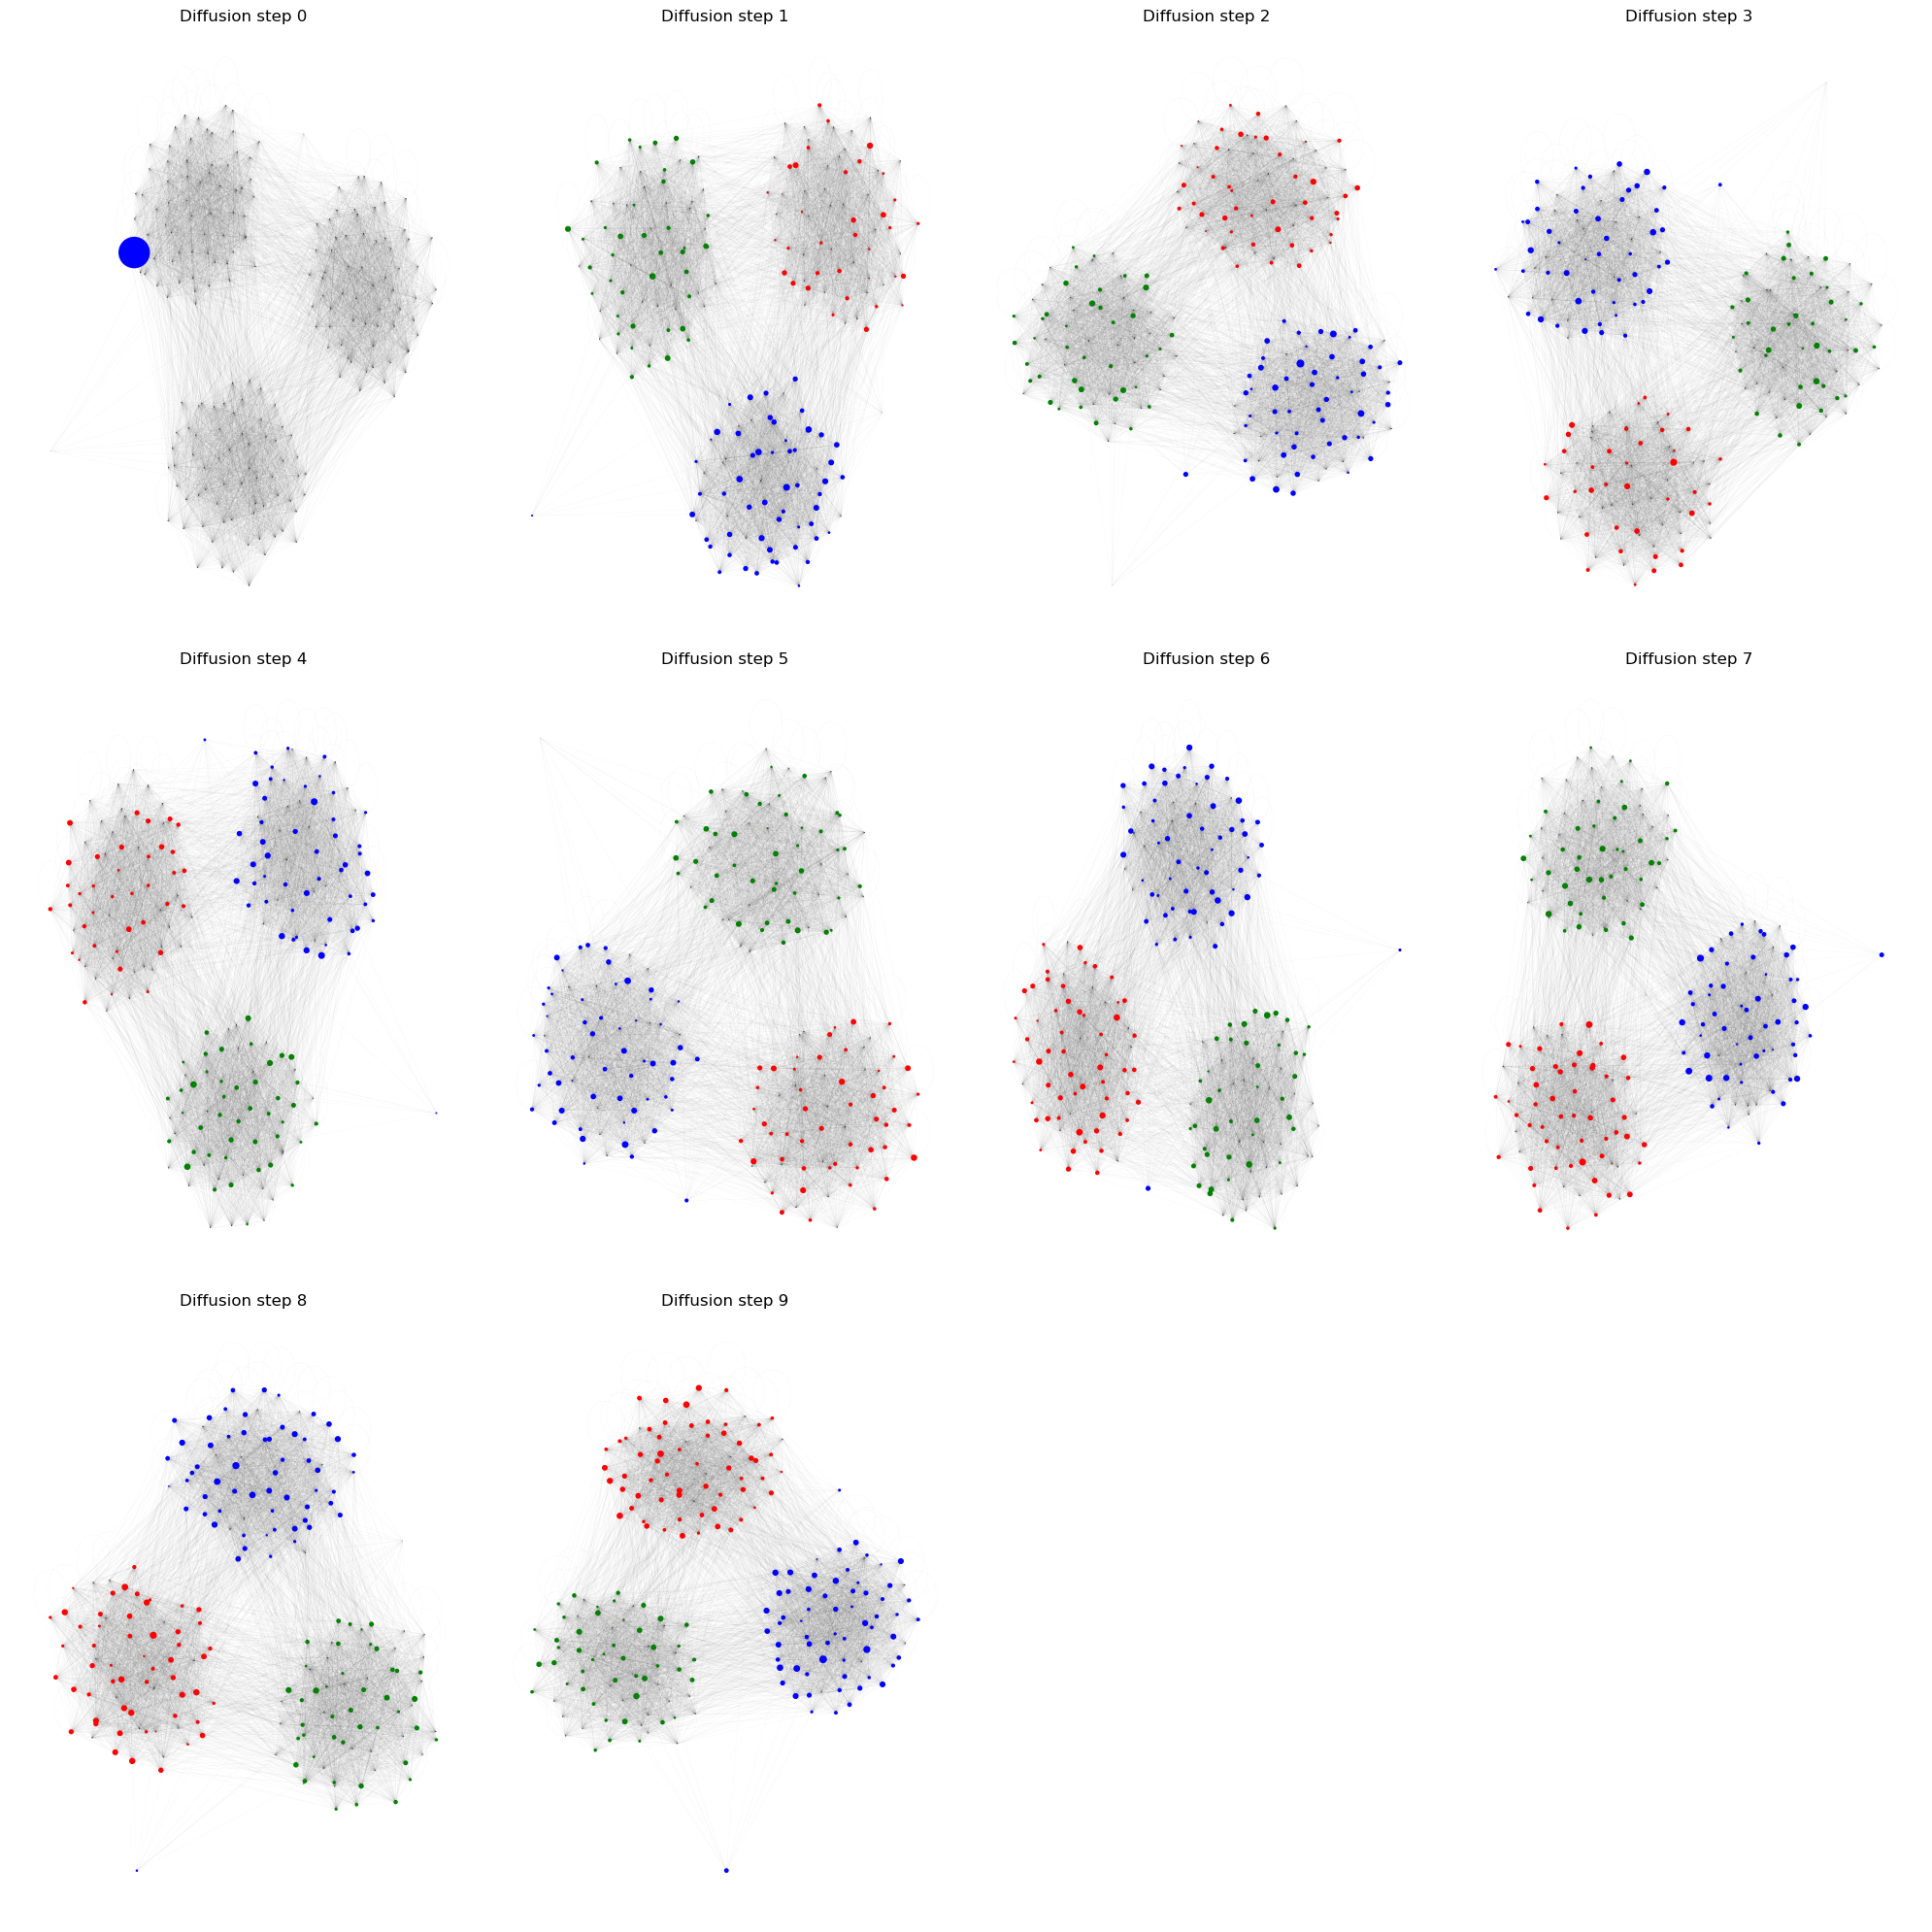

In [9]:
# Generate the signal
n_diffusions = 10  # Number of diffusion steps to show
source_node = 10   # Source node
color_mapping=['blue','red','green','purple','pink','black']
color_map = [color_mapping[i] for i in labels]

# Convert adjacency matrix to networkx graph
graph = nx.from_numpy_array(adjacency_matrix)

plt.figure(figsize=(20, 20))

for diffusion_i in range(n_diffusions):
    # Generate the signal at this diffusion step
    signal = generate_diffusion(adjacency_matrix, source_node, diffusion_i, noise_std=0.01, seed=42)
    signal = signal.numpy()
    
    # Draw the network
    plt.subplot(3, 4, diffusion_i + 1)
    nx.draw(graph, 
            node_color=color_map,
            node_size=signal * 500,  # Scale the node sizes by the signal values
            width=0.01)
    plt.title(f"Diffusion step {diffusion_i}")

plt.tight_layout()
plt.show()


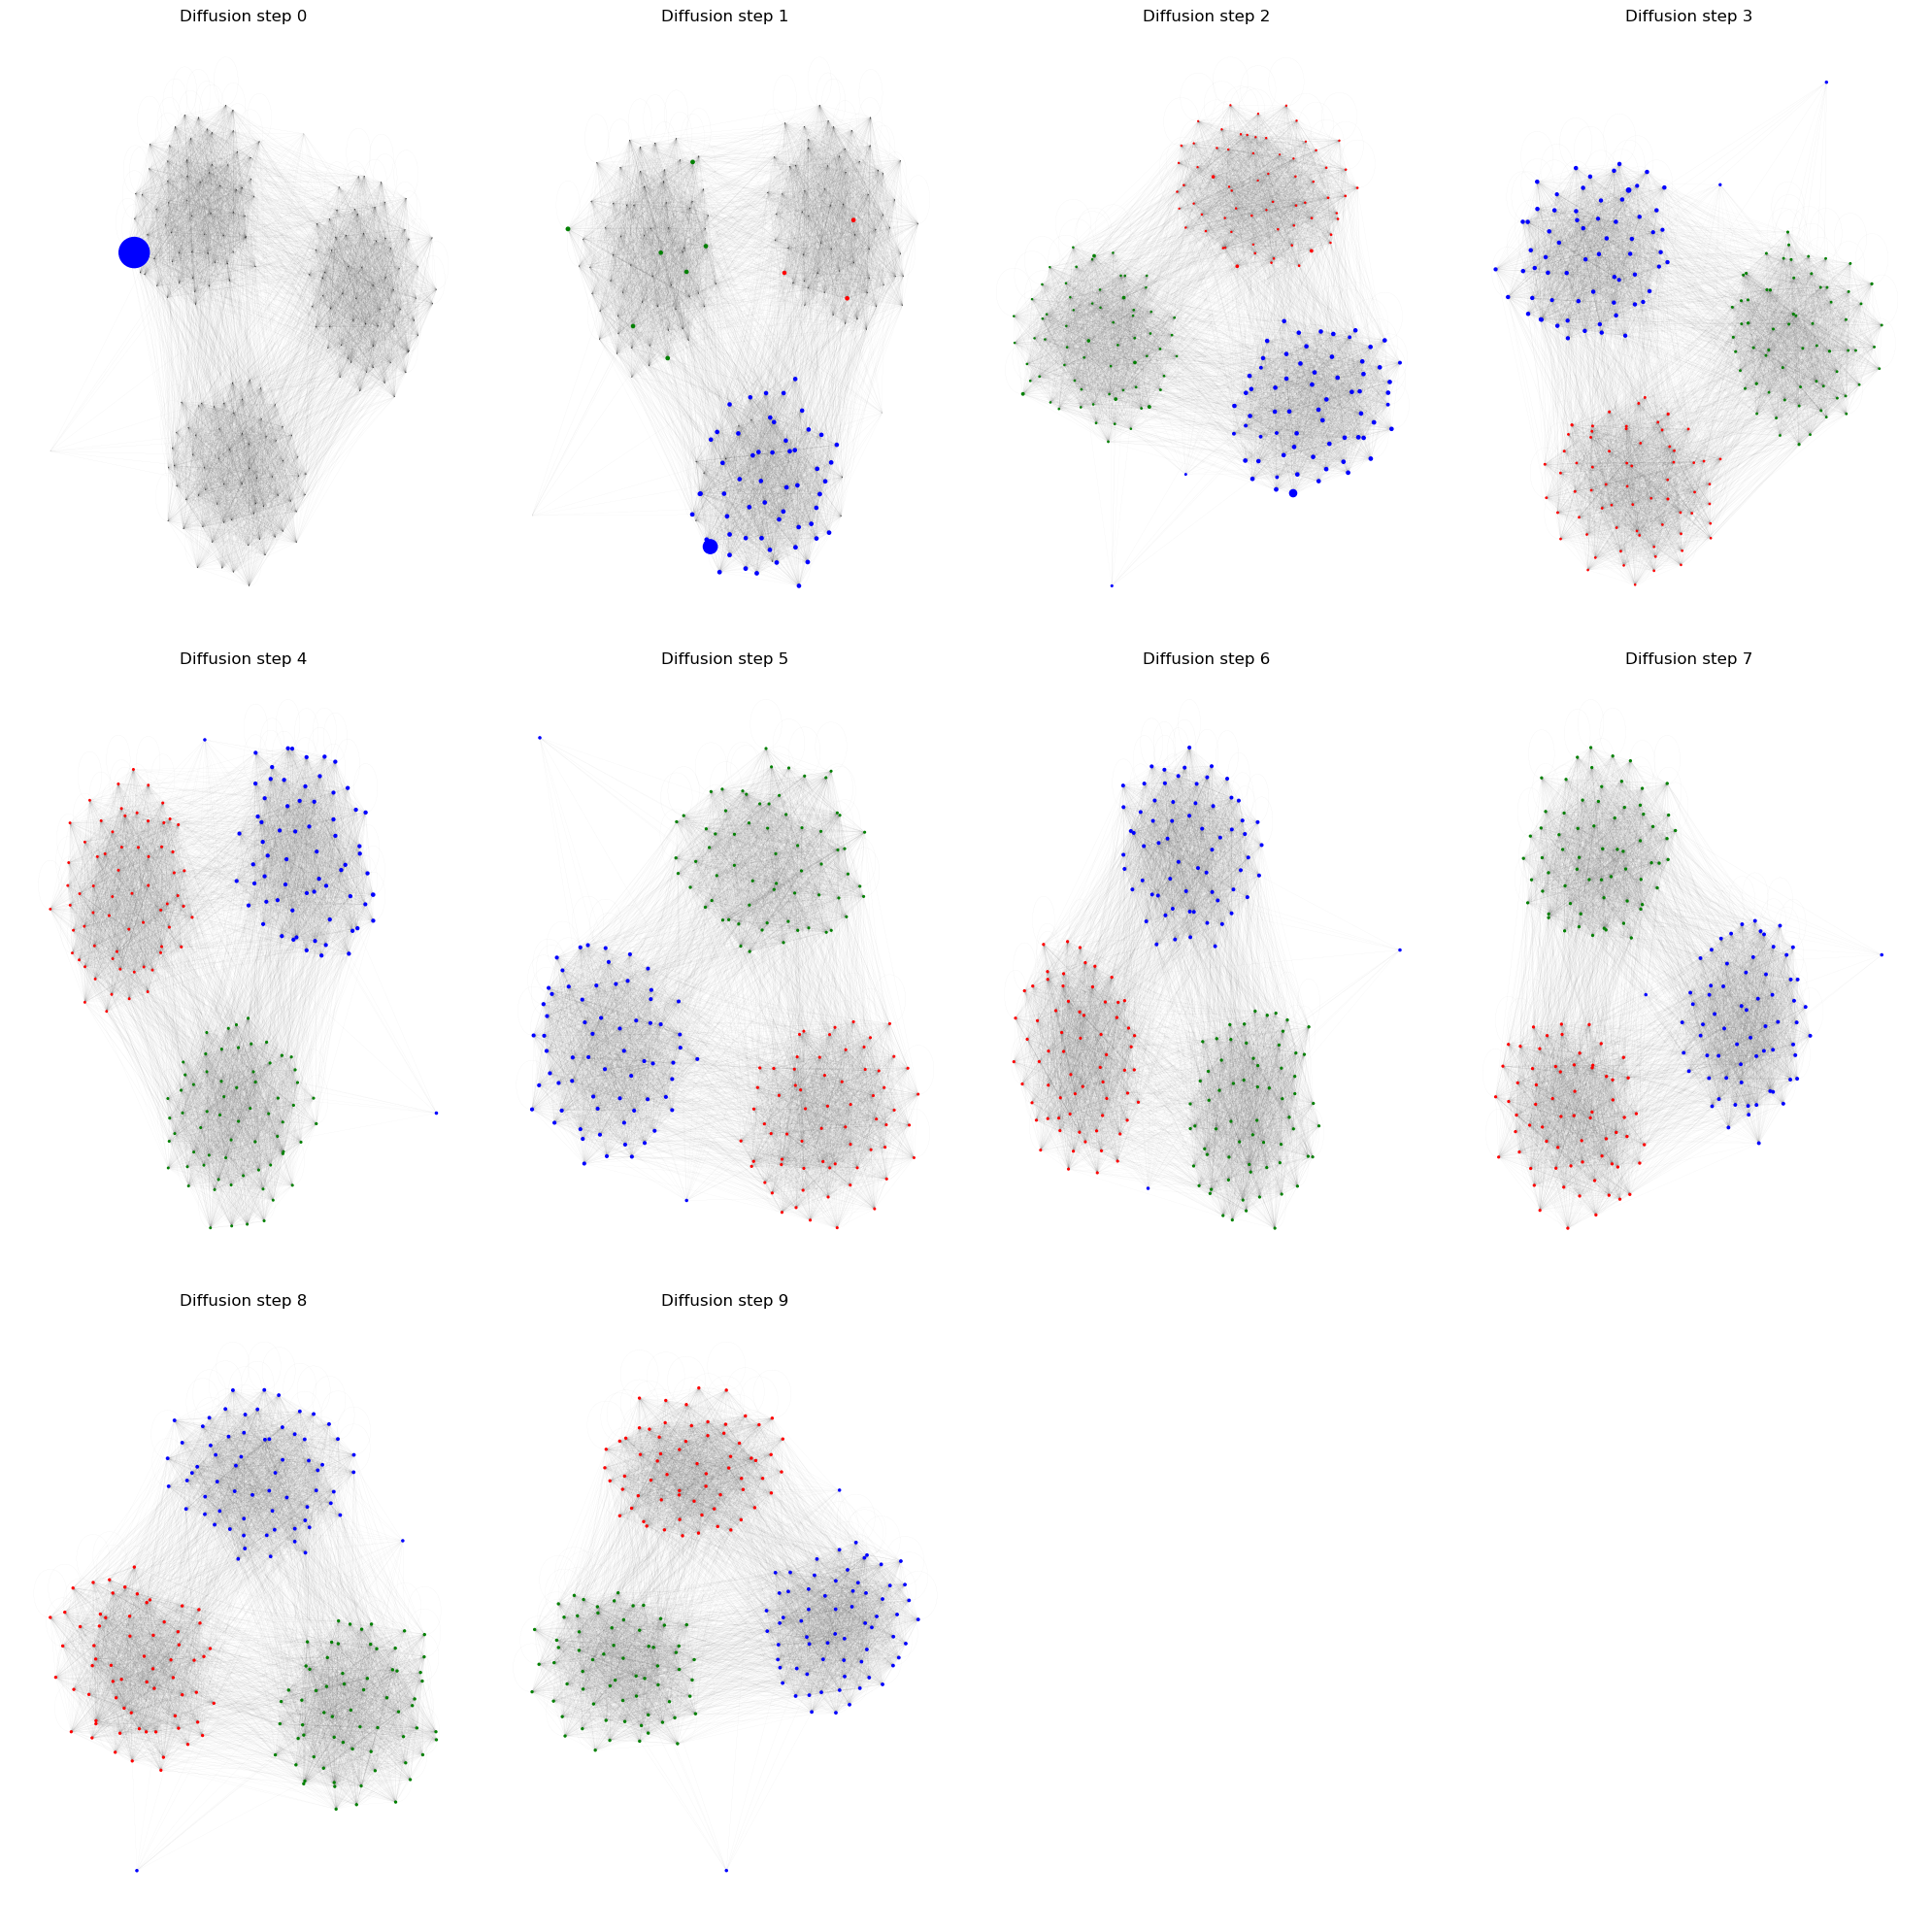

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# Generate the signal
n_diffusions = 10  # Number of diffusion steps to show
source_node = 10   # Source node
color_mapping=['blue','red','green','purple','pink','black']
color_map = [color_mapping[i] for i in labels]

# Convert adjacency matrix to networkx graph
graph = nx.from_numpy_array(adjacency_matrix)

plt.figure(figsize=(20, 20))

for diffusion_i in range(n_diffusions):
    # Generate the signal at this diffusion step
    signal = generate_diffusion2(adjacency_matrix, source_node, diffusion_i, seed=42)
    signal = signal.numpy()
    
    # Draw the network
    plt.subplot(3, 4, diffusion_i + 1)
    nx.draw(graph, 
            node_color=color_map,
            node_size=(signal * 500).tolist(),  # Scale the node sizes by the signal values
            width=0.01)
    plt.title(f"Diffusion step {diffusion_i}")

plt.tight_layout()
plt.show()


## 📚 Create database

Create a function that defines different instances of diffused graph signals, using for each instance a random source node and a random number of diffusion steps.

Afterwards, generate the dataset and split it into training, validation, and testing sets.

In [11]:
def create_dataset(total_samples, adjacency_matrix, maximum_diffusion_steps=10, noise_std=0.01, number_of_communities=3, seed=42):
  """
  Description:
  This function generates a dataset of diffused signals for a specified number of samples, given an adjacency matrix of a graph. 
  The diffusion process starts from randomly selected source nodes and is performed for a random number of diffusion steps. 
  The resulting dataset is returned as tensors of input signals (x) and corresponding labels (y).

  Parameters:

  total_samples (int): The total number of samples to generate in the dataset.
  adjacency_matrix (numpy.ndarray): A 2D array representing the adjacency matrix of the graph.
  maximum_diffusion_steps (int): The maximum number of diffusion steps to perform for each sample. 
    The actual number of diffusion steps is randomly selected for each sample from the range [0, maximum_diffusion_steps).
  noise_std (float): The standard deviation of the Gaussian noise added at each diffusion step.
  
  Returns:

  all_x (torch.Tensor): A 3D tensor representing the input signals (diffused signals) in the dataset [samples x N x 1].
  all_y (torch.Tensor): A 2D tensor representing the labels (one-hot encoded) corresponding to the community which originated the signal [samples x num_communities].
  """
  all_x = []
  all_y = []

  for i in range(total_samples):
    np.random.seed(i) 
    # Randomly select the source node and the number of diffusion steps
    source_node = np.random.randint(num_nodes)
    n_diffusions = np.random.randint(maximum_diffusion_steps) + 1

    # Generate the diffused signal
    signal = generate_diffusion2(adjacency_matrix, source_node, n_diffusions, noise_std=noise_std)
    #signal = generate_diffusion(adjacency_matrix, source_node, n_diffusions, noise_std=noise_std)
    all_x.append(signal.unsqueeze(-1))  # Adding feature dimension

    # Generate the corresponding label
    community_label = torch.tensor(labels[source_node]).long()  
    one_hot_label = torch.zeros(number_of_communities)  
    one_hot_label[community_label] = 1  
    all_y.append(one_hot_label)

  all_x = torch.stack(all_x)
  all_y = torch.stack(all_y)


  return all_x, all_y

In [12]:
train_size  = 200 # Number of training samples
val_size    = 50 # Number of validation samples
test_size   = 50 # Number of testing samples

total_samples = train_size + val_size + test_size

all_x, all_y = create_dataset(total_samples, adjacency_matrix, maximum_diffusion_steps=10, noise_std=0)

In [61]:
from torch_geometric.data import Data

def create_train_val_test(graph, all_x, all_y, train_size, val_size, test_size, num_communities):
  """
  This function splits the generated dataset into training, validation, and testing datasets 
  based on the specified sizes. 
  It creates separate datasets for each split, where each dataset consists of data objects with
  input signals (x) and labels (y) based on the generated diffused signals.

  Note:
  
  The training, validation, and testing datasets are returned as lists of PyTorch Geometric Data objects.
  """
  train_dataset = []
  val_dataset = []
  test_dataset = []

  # Create edge_index tensor
  edge_index = torch.tensor(list(graph.edges)).t().contiguous()

  for i in range(train_size):
    data = Data(x=all_x[i], edge_index=edge_index, y=all_y[i].view(1, num_communities))
    train_dataset.append(data)

  for i in range(train_size, train_size+val_size):
    data = Data(x=all_x[i], edge_index=edge_index, y=all_y[i].view(1, num_communities))
    val_dataset.append(data)

  for i in range(train_size+val_size, total_samples):
    data = Data(x=all_x[i], edge_index=edge_index, y=all_y[i].view(1, num_communities))
    test_dataset.append(data)

  return train_dataset, val_dataset, test_dataset

In [14]:
train_dataset, val_dataset, test_dataset = create_train_val_test(graph, all_x, all_y, train_size, val_size, test_size, 3)

#### Dataset sample

This is how one sample of your dataset should look like:

- **edge_index:** Graph connectivity in COO format with shape [2, num_edges]

- **x:** Input node features with shape [Nodes, Node features]. 
    The number of node features is 1 for for our case and it represents the value of the diffused graph signal

- **y:** Output graph signal, i.e. target feature. Shape [1, num_communities].

In [16]:
train_dataset[0]

Data(x=[200, 1], edge_index=[2, 7351], y=[1, 3])

In [17]:
# Print a few samples
for i in range(5): 
    print("Sample", i)
    print("Input signal (x):", train_dataset[i].x)
    print("Label (y):", train_dataset[i].y)
    print("Edge index:", train_dataset[i].edge_index)
    print()


Sample 0
Input signal (x): tensor([[0.0037],
        [0.0036],
        [0.0039],
        [0.0038],
        [0.0038],
        [0.0039],
        [0.0039],
        [0.0037],
        [0.0038],
        [0.0039],
        [0.0039],
        [0.0038],
        [0.0036],
        [0.0039],
        [0.0040],
        [0.0039],
        [0.0038],
        [0.0040],
        [0.0039],
        [0.0039],
        [0.0037],
        [0.0040],
        [0.0040],
        [0.0039],
        [0.0041],
        [0.0039],
        [0.0039],
        [0.0038],
        [0.0040],
        [0.0037],
        [0.0037],
        [0.0038],
        [0.0037],
        [0.0041],
        [0.0038],
        [0.0036],
        [0.0038],
        [0.0039],
        [0.0040],
        [0.0038],
        [0.0037],
        [0.0039],
        [0.0038],
        [0.0038],
        [0.0037],
        [0.0040],
        [0.0036],
        [0.0037],
        [0.0040],
        [0.0038],
        [0.0039],
        [0.0040],
        [0.0038],
        [0.0037],
 

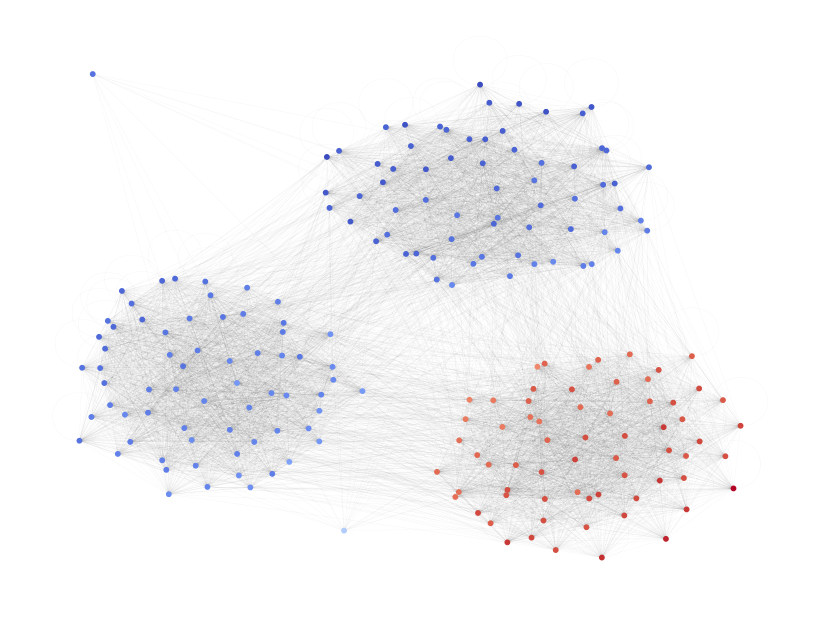

In [18]:
# Visualize a sample data 

import networkx as nx
import matplotlib.pyplot as plt

G = graph
sample_data = train_dataset[4]

# Extract the diffused signals and corresponding node indices
diffused_signals = sample_data.x.squeeze().numpy()
node_indices = range(len(diffused_signals))

# Node colors represent the diffused signals
plt.figure(figsize=(8, 6))
nx.draw(G, node_color=diffused_signals, cmap='coolwarm', node_size=10, width=0.01)
plt.show()


## 💻 Model definition and training

**Instructions:**
Define a GNN model class, instantiate it, and train it.

The GNN takes as input the diffused node signal and returns the estimate of which community originated it.

In [19]:
from torch_geometric.nn import ChebConv, GCNConv
from torch_geometric.loader import DataLoader

import torch.nn as nn
import torch.nn.functional as F

In [20]:
class Net(torch.nn.Module):    
    """
    Graph neural network (GNN) model for community detection.
    
    Args:
        num_communities (int): Number of communities in the graph.
        num_nodes (int): Number of nodes in the graph.
        hid_features (int): Number of hidden features in the GNN layers.
    """
    def __init__(self, num_communities, num_nodes, hid_features=32):
        super(Net, self).__init__()

        self.conv1 = ChebConv(1, hid_features, K=2) 
        self.conv2 = ChebConv(hid_features, num_communities, K=2)



    def forward(self, data):

        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)

    
        return x

#### Model instantiation

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net(num_communities, num_nodes, hid_features=16).to(device)

### 🏋🏽‍♀️Train a Graph Neural Network

Train your GNN model. 

Define the training and evaluation functions.

Pay attention to which loss function you are going to use.

#### Define the training and evaluation functions.

In [22]:
def train_epoch(model, loader, optimizer, device='cpu'):
  """
    Trains a neural network model for one epoch using the specified data loader and optimizer.

    Args:
        model (nn.Module): The neural network model to be trained.
        loader (DataLoader): The PyTorch Geometric DataLoader containing the training data.
        optimizer (torch.optim.Optimizer): The PyTorch optimizer used for training the model.
        device (str): The device used for training the model (default: 'cpu').

    Returns:
        float: The mean loss value over all the batches in the DataLoader.

    """
  model.to(device)
  model.train() # specifies that the model is in training mode
  
  total_loss = 0
  
  for data in loader:
      data = data.to(device)
      optimizer.zero_grad() 
      out = model(data) 
      target = data.y.argmax(dim=1)[data.batch]
      #print("Out shape: ", out.shape)
      #print("Target shape: ", target.shape)
      loss = F.nll_loss(out, target) 
      loss.backward() 
      optimizer.step() 
      total_loss += loss.item() * data.num_graphs

  loss =  total_loss / len(loader.dataset)

  return loss

In [23]:
@torch.no_grad()
def evaluate_epoch(model, loader, device='cpu'):
    """
    Evaluates the performance of a trained neural network model on a dataset using the specified data loader.

    Args:
        model (nn.Module): The trained neural network model to be evaluated.
        loader (DataLoader): The PyTorch Geometric DataLoader containing the evaluation data.
        device (str): The device used for evaluating the model (default: 'cpu').

    Returns:
        float: The mean loss value over all the batches in the DataLoader.

    """
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for data in loader:
        data = data.to(device)
        out = model(data)
        target = data.y.argmax(dim=1)[data.batch]
        loss = F.nll_loss(out, target)
        total_loss += loss.item() * data.num_graphs
        total_correct += (out.argmax(dim=1) == target).sum().item()
        total_samples += data.num_graphs

    loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return loss, accuracy

#### Define the DataLoaders and the optimizer

In [24]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

#### Train the model

In [25]:
train_losses = []
val_losses = []

for epoch in range(20):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_accuracy = evaluate_epoch(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch: 0, Train Loss: 1.1166, Validation Loss: 1.1463, Validation Accuracy: 64.0000
Epoch: 1, Train Loss: 1.1143, Validation Loss: 1.1099, Validation Accuracy: 48.6000
Epoch: 2, Train Loss: 1.1057, Validation Loss: 1.0975, Validation Accuracy: 88.0000
Epoch: 3, Train Loss: 1.1055, Validation Loss: 1.0985, Validation Accuracy: 48.0000
Epoch: 4, Train Loss: 1.0992, Validation Loss: 1.0986, Validation Accuracy: 64.0000
Epoch: 5, Train Loss: 1.1066, Validation Loss: 1.0894, Validation Accuracy: 88.0000
Epoch: 6, Train Loss: 1.1071, Validation Loss: 1.1290, Validation Accuracy: 48.0000
Epoch: 7, Train Loss: 1.1030, Validation Loss: 1.0873, Validation Accuracy: 88.0000
Epoch: 8, Train Loss: 1.1074, Validation Loss: 1.1081, Validation Accuracy: 48.0000
Epoch: 9, Train Loss: 1.1062, Validation Loss: 1.1008, Validation Accuracy: 48.0000
Epoch: 10, Train Loss: 1.1073, Validation Loss: 1.0985, Validation Accuracy: 64.0000
Epoch: 11, Train Loss: 1.1044, Validation Loss: 1.0997, Validation Accuracy

## 📈 Results

#### Visualize loss and testing results

Plot the training and validation losses as a function of the epochs and analyse the performance of the network.

In [34]:
_, test_accuracy = evaluate_epoch(model, test_loader, device)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Test Accuracy: 75.9000


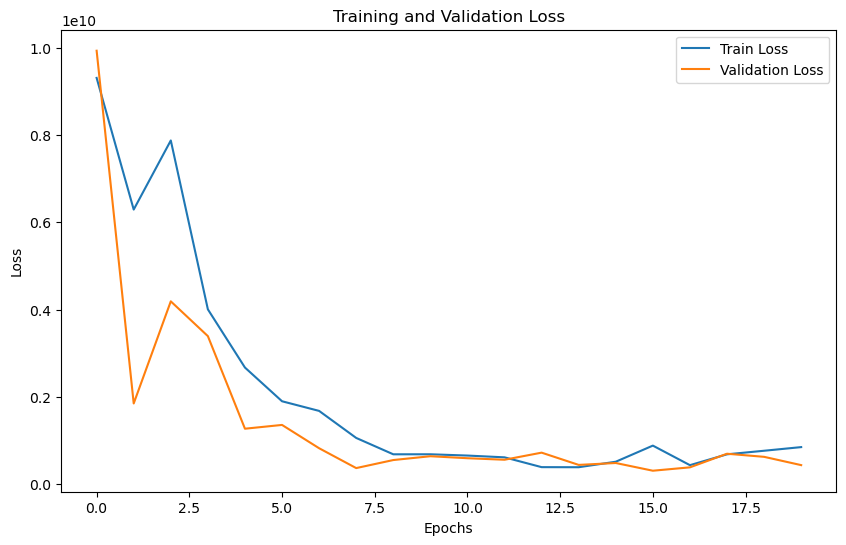

In [37]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

* What is the final testing accuracy? How does it relate to the training performance of the network?

#### Answers

The final test accuracy is 75.9. Depending on the run the model the accuracy has sometimes been higher, reaching even 100% accuracy. This is probably due to the fact that the model is not very robust and can easily get stuck in a local minimum. The figure showing the training and validation loss as a number of epochs indicates the model is learning correctly. 

The final testing accuracy is around 100%, which is equal to the validation loss, implying that the model was correctly trained.

## Effects of noise level

Generate data with increased noise levels and re-train your model.

Plot test accuracy versus noise for at least 5 noise levels.

In [52]:
noise_levels = [10e-5, 10e-2, 10e-1, 1, 10e1, 10e2]

train_size  = 200 # Number of training samples
val_size    = 50 # Number of validation samples
test_size   = 50 # Number of testing samples
total_samples = train_size + val_size + test_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_test_accuracies = []
final_test_accuracies = []

for noise in noise_levels:
    all_x, all_y = create_dataset(total_samples, adjacency_matrix, maximum_diffusion_steps=10, noise_std=noise)
    train_dataset, val_dataset, test_dataset = create_train_val_test(graph, all_x, all_y, train_size, val_size, test_size)
    model = Net(num_communities, num_nodes, hid_features=16).to(device)
    

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

    train_losses = []
    val_losses = []
    test_accuracies = []

    for epoch in range(20):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_accuracy = evaluate_epoch(model, val_loader, device)
        test_loss, test_accuracy = evaluate_epoch(model, test_loader, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_accuracies.append(test_accuracy)
        #if epoch % 5 == 0:
            #print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    best_test_accuracy = max(test_accuracies)
    final_test_accuracy = test_accuracies[-1]

    best_test_accuracies.append(best_test_accuracy)
    final_test_accuracies.append(final_test_accuracy)



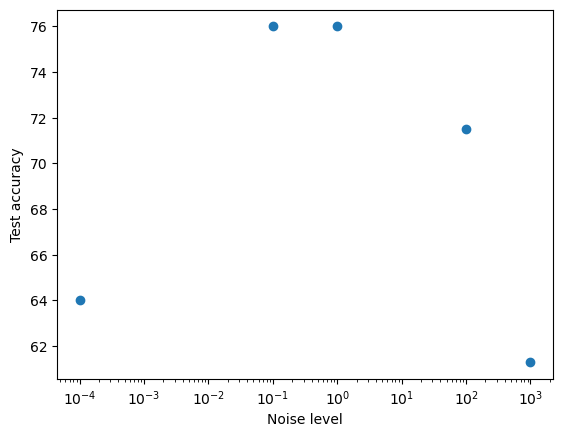

In [47]:
# Make the test_accs dictionary from the lists of noise levels and test accuracies
test_accs = dict(zip(noise_levels, final_test_accuracies))

plt.scatter(test_accs.keys(), test_accs.values())
plt.xlabel("Noise level")
plt.ylabel("Test accuracy")
plt.xscale('log')

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

* What do you conclude if the noise level increases?

#### Answers:

In the figure above, the test accuracy versus the noise level is plotted. Ignoring the outlier of very low noise, the graph follows the expected trend. As the noise increases, the accuracy decreases. This is expected since the noise is added to the signal, and the model has to learn to ignore it. The maximum accuracy is reached at 75.9, as mentioned above. As the level of noise is increased, the accuracy decreases to a minimum below 62. The outlier for very low noise could be due to a floating point precision error. I debugged extensively the training data generation, hence all the figures shown in previous parts of the assignment, but could not find any problem with the process.

## Effect on number of commuities

Generate data with increased number of communities and re-train your model.

Plot test accuracy versus number of communities for at least 5 values.

In [63]:
number_of_communities = [3, 4, 5, 6, 7, 8, 9, 10]

num_nodes = 200 # Number of nodes # Original: 200
num_communities = 3 # Number of communities

intra_prob = 0.7 # Probability of drawing edges intra communities
inter_prob = 0.1 # Probability of drawing edges inter communities

train_size  = 200 # Number of training samples
val_size    = 50 # Number of validation samples
test_size   = 50 # Number of testing samples
total_samples = train_size + val_size + test_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_test_accuracies = []
final_test_accuracies = []

for number in number_of_communities:
    print(f"Number of communities: {number}")
    adjacency_matrix, labels = generate_sbm_graph(num_nodes, number, intra_prob, inter_prob, seed=42)
    graph = nx.from_numpy_array(adjacency_matrix)
    
    all_x, all_y = create_dataset(total_samples, adjacency_matrix, maximum_diffusion_steps=10, noise_std=noise, number_of_communities=number)
    train_dataset, val_dataset, test_dataset = create_train_val_test(graph, all_x, all_y, train_size, val_size, test_size, num_communities=number)
    model = Net(number, num_nodes, hid_features=16).to(device)
    

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

    train_losses = []
    val_losses = []
    test_accuracies = []

    for epoch in range(20):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_accuracy = evaluate_epoch(model, val_loader, device)
        test_loss, test_accuracy = evaluate_epoch(model, test_loader, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_accuracies.append(test_accuracy)
        #if epoch % 10 == 0:
        #print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    best_test_accuracy = max(test_accuracies)
    final_test_accuracy = test_accuracies[-1]

    best_test_accuracies.append(best_test_accuracy)
    final_test_accuracies.append(final_test_accuracy)

Number of communities: 3
Number of communities: 4
Number of communities: 5
Number of communities: 6
Number of communities: 7
Number of communities: 8
Number of communities: 9
Number of communities: 10


### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

* How is the performance affected by the number of communities?

#### Answers

The test accuracy steadily decreases as the number of communities is increased, as expected, since the model has a harder time learning to distinguish between more communities. If more communities are required, a possible solution would be to increase the complexity of the model architecture and the number of training samples, at the expense of computational resources. 

Text(0, 0.5, 'Test accuracy')

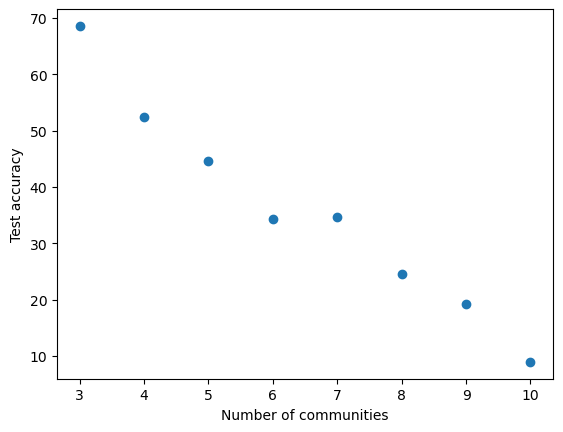

In [66]:
# Make the test_accs dictionary from the lists of the number of communities and test accuracies
test_accs = dict(zip(number_of_communities, final_test_accuracies))

plt.scatter(test_accs.keys(), test_accs.values())
plt.xlabel("Number of communities")
plt.ylabel("Test accuracy")